# scASTRAL training

In [11]:
import pickle as pkl
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from conorm import cpm
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)
from scastral import *

In [2]:
train = pd.read_csv('data/train_set.csv')
train.set_index('barcodes',inplace=True,drop=True)  # set barcodes as index
labels = train['survived']  #  get labels

#### load afatinib drug response singature

In [3]:
signature = pd.read_csv('data/signature.csv')
signature = list(signature['ensembl_gene_id'])

#### Preprocessing ( filtering, normalization and feature selection)

In [4]:
cell_filter,_ = utils.filter_data(train)
train = train.loc[cell_filter,:]
X = pd.DataFrame(cpm(train.T,norm_factors='TMM').T)
X.columns = train.columns
train = X.loc[:,signature] # subset to signature

#### Train the model

In [10]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
scores = []
best_score = -np.inf
for fold, (train_idx,valid_idx) in enumerate(kfold.split(train,labels)):
   clf = SVC(kernel=cosine_similarity,probability=True,C=100)
   model = network.SCAstral(max_epochs=250,input_size=train.shape[1],hidden_size=64, latent_size=32,patience=20,alfa=.1, sigma=.1, mu=.1,
                   theta = 5,lr=.0001,verbose=False,path='models/scmuta.pt',predictor = clf, metric=accuracy_score)

   preprocessing_pipe = Pipeline([ ('gf-icf',preprocessing.GfIcfTransformer()),('scaler',MinMaxScaler()) ])
   classification_pipe = Pipeline([('SCAE',model),('clf',clf)])
   pipe = Pipeline([ ('preprocessing',preprocessing_pipe),('classification',classification_pipe)])

   X_train = train.iloc[train_idx,:]
   X_valid = train.iloc[valid_idx,:]
   y_train = labels[train_idx]
   y_valid = labels[valid_idx]

   preprocessing_pipe.fit(X_train)
   model.set_valid_data(preprocessing_pipe.transform(X_valid), y_valid)

   pipe.fit(X_train,y_train)

   pred = pipe.predict(X_valid)
   score = accuracy_score(y_valid, pred)

   if score > best_score:
        pkl.dump(pipe,open('models/scASTRAL_pipeline.sk','wb'))
        best_score = score
   scores.append(score)
   print(f'{fold+1}th fold score: {score}')
print(f'mean score: {np.mean(scores)}')

best epoch 38
1th fold score: 0.7669902912621359
best epoch 22
2th fold score: 0.7012987012987013
best epoch 73
3th fold score: 0.7532467532467533
best epoch 15
4th fold score: 0.7175324675324676
best epoch 26
5th fold score: 0.7012987012987013
mean score: 0.7280733829277519


#### Compare inter and intra cluster distance before and after training

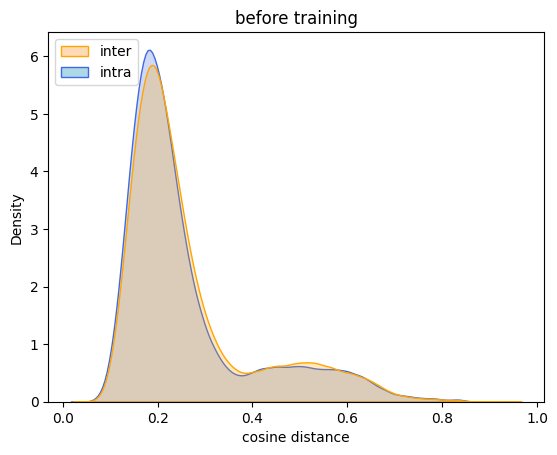

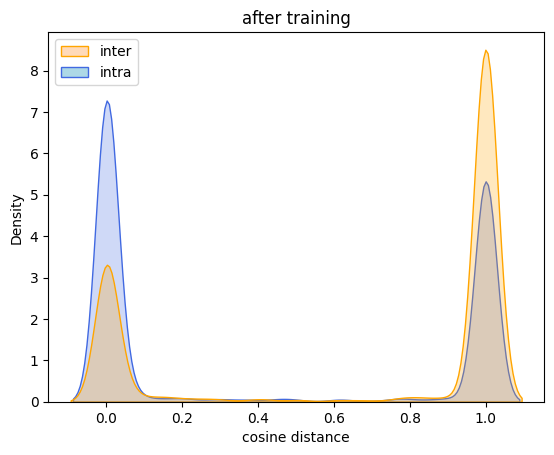

In [12]:

data = pipe[0].transform(train)
transformed = pipe[0].transform(train)
transformed = pipe[1][0].transform(transformed)
mask = np.array(labels, dtype=bool)

# compute cosine distance before transformation
sxsb = cosine_distances(data[mask, :])  # survived on survived
sxdb = cosine_distances(data[mask, :], data[~mask, :])  # survived on dead
dxdb = cosine_distances(data[~mask, :])  # dead on dead

# compute cosine distance after transformation
sxsa = cosine_distances(transformed[mask, :])  # survived on survived
sxda = cosine_distances(transformed[mask, :], transformed[~mask, :])  # survived on dead
dxda = cosine_distances(transformed[~mask, :])  # dead on dead

np.fill_diagonal(sxsb, np.nan)  # remove diagonal elements
np.fill_diagonal(sxdb, np.nan)  # remove diagonal elements
np.fill_diagonal(dxdb, np.nan)  # remove diagonal elements
np.fill_diagonal(sxsa, np.nan)  # remove diagonal elements
np.fill_diagonal(sxda, np.nan)  # remove diagonal elements
np.fill_diagonal(dxda, np.nan)  # remove diagonal elements

# flatten distance matrix
inter_b = sxdb.flatten()
intra_b = np.concatenate((sxsb.flatten(), dxdb.flatten()))
inter_a = sxda.flatten()
intra_a = np.concatenate((sxsa.flatten(), dxda.flatten()))

# plot distribution before transformation
sns.kdeplot(intra_b, color='royalblue', fill=True, legend='intra')
sns.kdeplot(inter_b, color='orange', fill=True, legend='inter')
plt.title('before training')
plt.xlabel('cosine distance')
legend_elements = [Patch(facecolor='peachpuff', edgecolor='orange',
                         label='inter'), Patch(facecolor='lightblue', edgecolor='royalblue',
                                               label='intra')]
plt.legend(handles=legend_elements, loc='upper left')
plt.savefig('before.pdf')
plt.show()

# plot distribution after transformation
sns.kdeplot(intra_a, color='royalblue', fill=True, legend='intra')
sns.kdeplot(inter_a, color='orange', fill=True, legend='inter')
plt.title('after training')
plt.xlabel('cosine distance')
plt.legend(handles=legend_elements, loc='upper left')
plt.savefig('after.pdf')
plt.show()